In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']

# Load the train dataset
ais = pd.read_csv('felixstowe_rotterdam.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})


# Load test dataset, only needed for presentation
# ais = pd.read_csv('flex_rot.arff', names = names, skiprows = 27, parse_dates = True,
#                   na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
# Copy dataset with different name, avoids reloading dataset for every mishap
ais_nan = ais

In [4]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [5]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan

In [6]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [7]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [8]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [9]:
# Set invalid breadths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [10]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [11]:
# Drop irrelevant Information
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

Text(0.5,1,'All Positions Before Filtering')

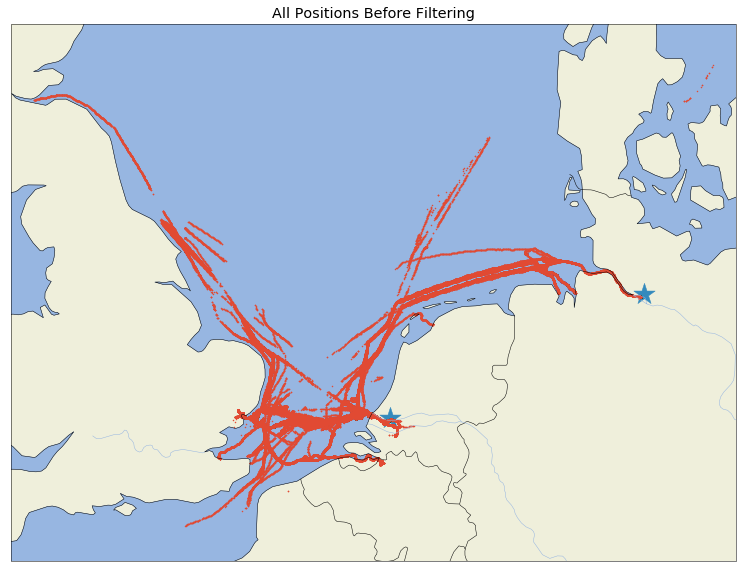

In [12]:
# Plot all positions in the data before any filters are applied

aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,'Start Positions Before Filtering')

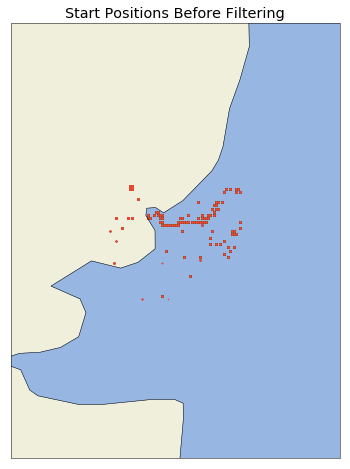

In [13]:
# Plot start positions before any filtering to map

aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,'End Positions Before Filtering')

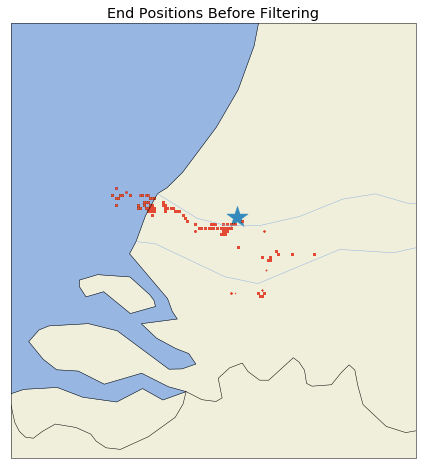

In [14]:
# Plot end positions before any filtering to map

aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
plt.title("End Positions Before Filtering")

In [15]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 0.97) | (ais_dropped['Longitude'] > 4.8)
outside_lat_mask = (ais_dropped['Latitude'] < 51.62) | (ais_dropped['Latitude'] > 52.3)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,'All Positions After Filtering to Our Zone')

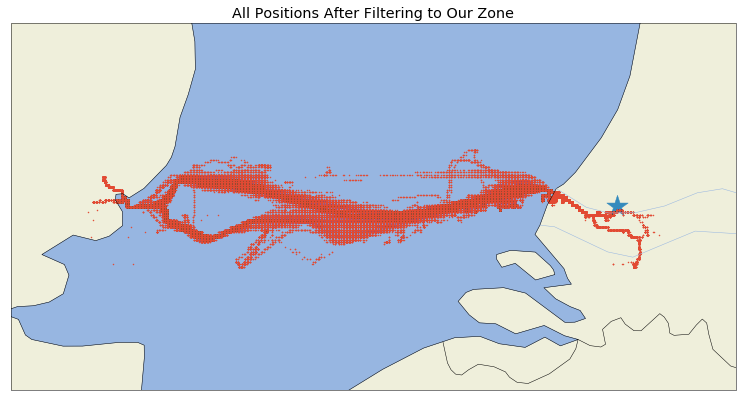

In [16]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

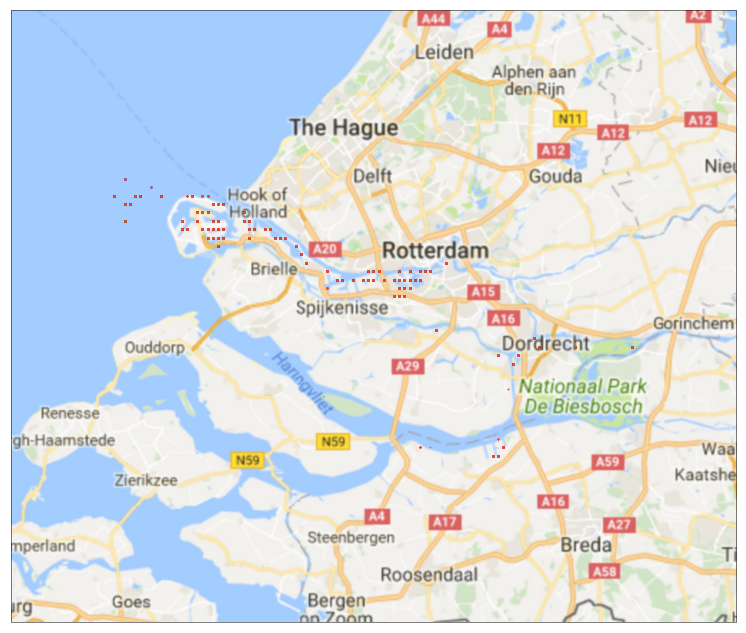

In [17]:
minlat = ais_zoned['EndLatitude'].min() - 0.2
maxlat = ais_zoned['EndLatitude'].max() + 0.2
minlong = ais_zoned['EndLongitude'].min() - 0.2
maxlong = ais_zoned['EndLongitude'].max() + 0.2

aismap.plot_google_map((minlong, maxlong, minlat, maxlat))
plt.scatter(x = ais_zoned['EndLongitude'], y = ais_zoned['EndLatitude'] , transform = ccrs.PlateCarree(), s = 1)

In [18]:
# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_zoned[ais_zoned['Longitude'] > 3.94].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_zoned[ais_zoned['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

/home/vhanke/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


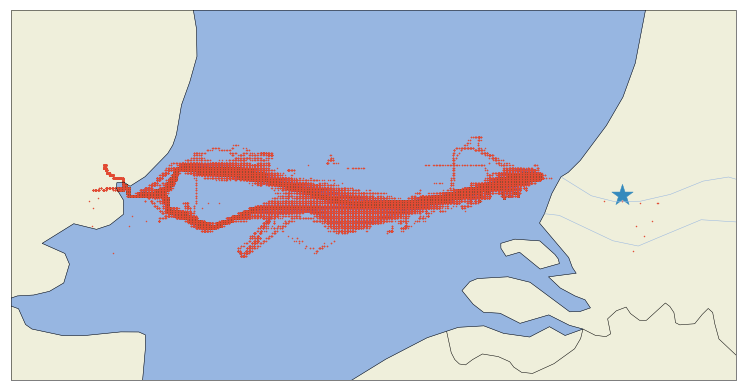

In [19]:
aismap.plot_to_map(size = (13, 13), longitude = ais_ham_zoned['Longitude'], latitude = ais_ham_zoned['Latitude'])

In [20]:
ais_tts = ais_ham_zoned
ais_tts.is_copy = False   # Hack to silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

/home/vhanke/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/vhanke/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


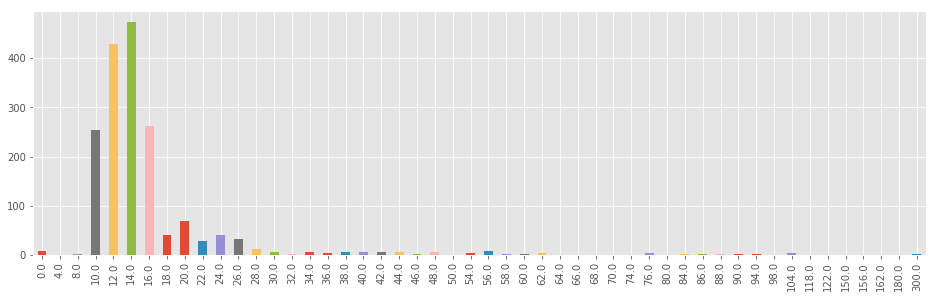

In [21]:
# get figure of triptime distribution

travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
travel_times = travel_times.transform(lambda x : (x.total_seconds() // 3600) * 2)
travel_times.value_counts().sort_index().plot.bar(figsize = (16, 4.5))

# plt.savefig('../Images/fel_rot_traveltimes_before.png', dpi = 300, bbox_inches = 'tight')

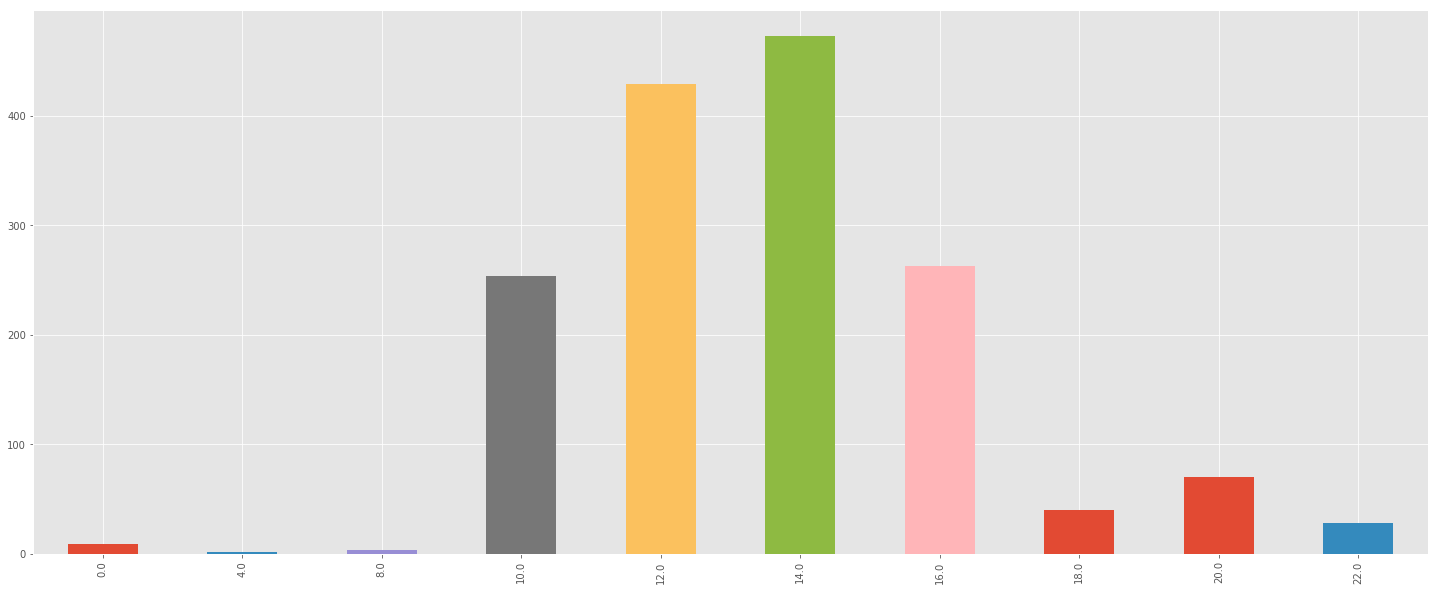

In [22]:
# Show trips after filtering by quantile

travel_times[travel_times < travel_times.quantile(.90)].value_counts().sort_index().plot.bar(figsize = (25, 10))

In [23]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[(ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.90)) & (ais_tts['TravelTimeMins'] > 270)]

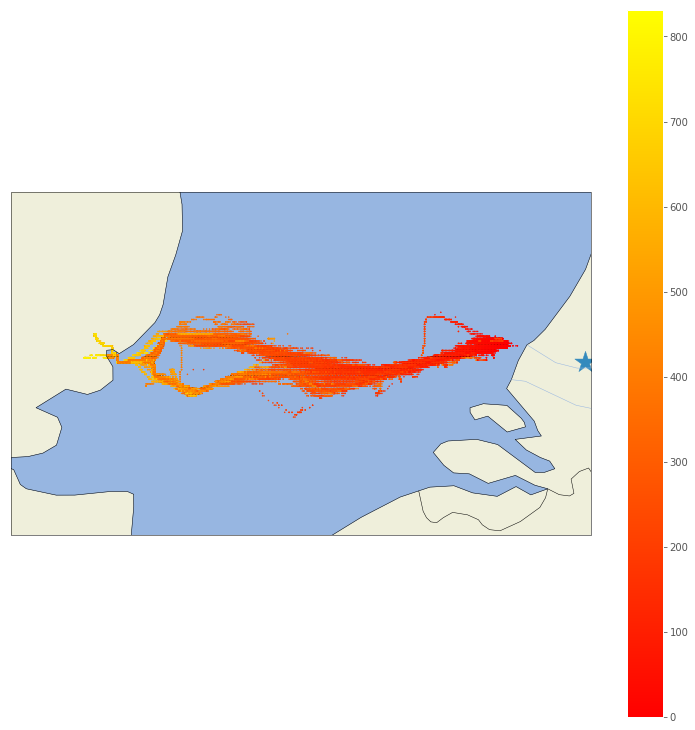

In [24]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [25]:
# Get and plot the longest trip in the data set
longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
longest_trip.head()

TripID  StartLatitude  StartLongitude           StartTime  \
169149  439330          51.94            1.31 2016-07-24 15:11:00   
169150  439330          51.94            1.31 2016-07-24 15:11:00   
169151  439330          51.94            1.31 2016-07-24 15:11:00   
169152  439330          51.94            1.31 2016-07-24 15:11:00   
169153  439330          51.94            1.31 2016-07-24 15:11:00   

        EndLatitude  EndLongitude             EndTime                time  \
169149        51.97          4.03 2016-07-25 05:02:00 2016-07-24 15:15:00   
169150        51.97          4.03 2016-07-25 05:02:00 2016-07-24 15:17:00   
169151        51.97          4.03 2016-07-25 05:02:00 2016-07-24 15:19:00   
169152        51.97          4.03 2016-07-25 05:02:00 2016-07-24 15:20:00   
169153        51.97          4.03 2016-07-25 05:02:00 2016-07-24 15:21:00   

        Length  Breadth      ...        Longitude  SOG    COG     TH  \
169149   363.0     46.0      ...             1.31  0.8  233.4  347.0   
169150   363.0     46.0      ...             1.31  0.6  133.9  359.0   
169151   363.0     46.0      ...             1.31  1.3  221.1   13.0   
169152   363.0     46.0      ...             1.31  1.4  236.9   24.0   
169153   363.0     46.0      ...             1.31  1.7  252.1   37.0   

        Destination  Callsign TravelTime TravelTimeMins remainingTT  \
169149    ROTTERDAM     2CBJ6   13:51:00          831.0    13:47:00   
169150    ROTTERDAM     2CBJ6   13:51:00          831.0    13:45:00   
169151    ROTTERDAM     2CBJ6   13:51:00          831.0    13:43:00   
169152    ROTTERDAM     2CBJ6   13:51:00          831.0    13:42:00   
169153    ROTTERDAM     2CBJ6   13:51:00          831.0    13:41:00   

        remainingMins  
169149          827.0  
169150          825.0  
169151          823.0  
169152          822.0  
169153          821.0  

[5 rows x 22 columns]

Text(0.5,1,'Longest Trip in the Data Set')

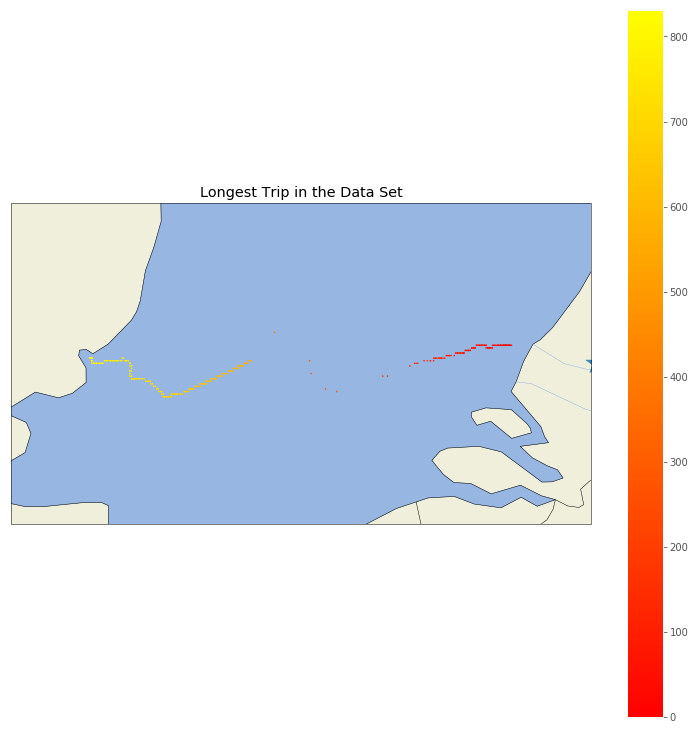

In [26]:
aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
plt.title("Longest Trip in the Data Set")

In [27]:
ais_tfeats = ais_shortmaj
ais_tfeats.is_copy = False

# Implement new features
ais_tfeats['hour_of_day'] = ais_tfeats['time'].dt.hour
ais_tfeats['weekday'] = ais_tfeats['time'].dt.dayofweek
ais_tfeats['day_of_month'] = ais_tfeats['time'].dt.day
ais_tfeats['month'] = ais_tfeats['time'].dt.month

/home/vhanke/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/vhanke/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [28]:
# experiment with interpolation

ais_interpol = ais_tfeats.copy()
ais_interpol.index = ais_interpol['time']
ais_interpol = ais_interpol.groupby('TripID').apply(lambda x : x.resample('T').mean().interpolate(method='linear')).reset_index()

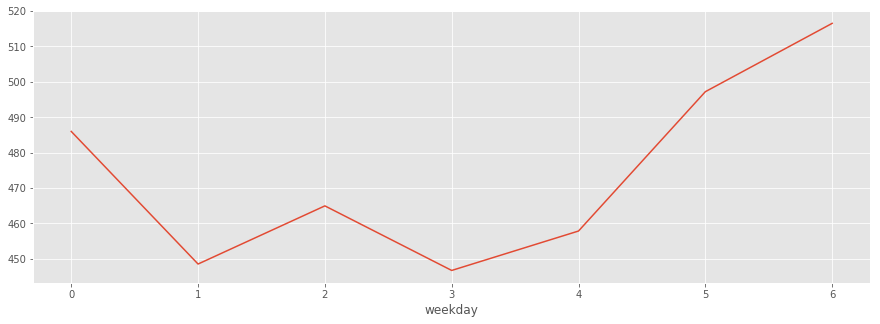

In [29]:
ais_tfeats.groupby('weekday')['TravelTimeMins'].mean().plot(figsize = (15, 5))

In [30]:
# Assign sector IDs according to Longitude ranges (3 sectors for FEL-ROT route)
def assign_sectors(ais_before):
    ais_after = ais_before.copy()
    
    ais_after.loc[(ais_after['Longitude'] <= 2.2) , 'sector'] = '0'
    ais_after.loc[(ais_after['Longitude'] <= 3.2) & (ais_after['Longitude'] > 2.2), 'sector'] = '1'
    ais_after.loc[(ais_after['Longitude'] <= 3.94) & (ais_after['Longitude'] > 3.2), 'sector'] = '2'
    ais_after.loc[ais_after['Longitude'] > 3.94, 'sector'] = np.nan
    
    return ais_after

ais_sectors = assign_sectors(ais_tfeats)

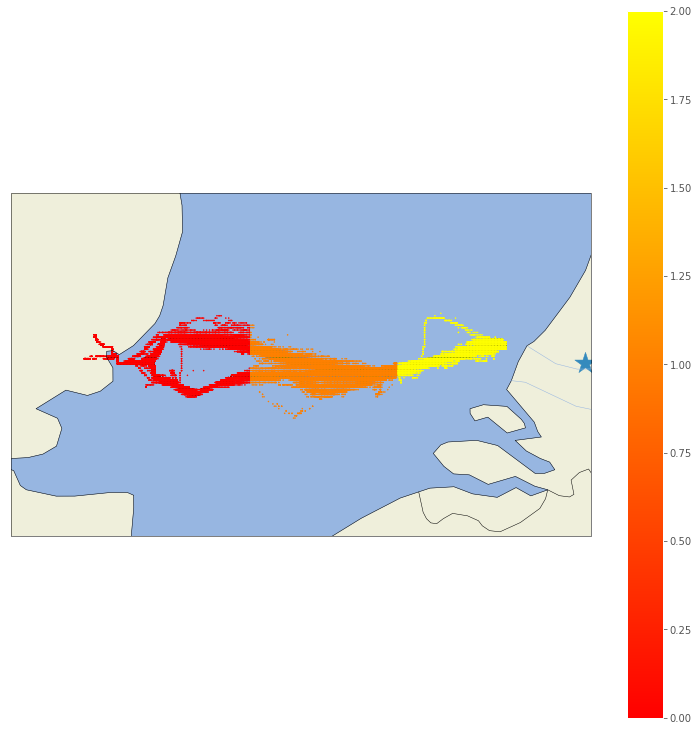

In [31]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_sectors['Longitude'], latitude = ais_sectors['Latitude'], col = ais_sectors['sector'])

In [32]:
ais_secleav = ais_sectors.copy()
ais_secleav = ais_secleav.sort_values('time')

# Seperate all data into individiual trips, create temporary information about next position of trip 
ais_secleav['next_lat'] = ais_secleav.groupby('TripID')['Latitude'].shift(-1)
ais_secleav['next_lon'] = ais_secleav.groupby('TripID')['Longitude'].shift(-1)
ais_secleav['next_time'] = ais_secleav.groupby('TripID')['time'].shift(-1)
ais_secleav['next_sog'] = ais_secleav.groupby('TripID')['SOG'].shift(-1)
ais_secleav['next_cog'] = ais_secleav.groupby('TripID')['COG'].shift(-1)
ais_secleav['next_sector_id'] = ais_secleav.groupby('TripID')['sector'].shift(-1)
ais_secleav = ais_secleav.sort_values(['TripID', 'time'])
ais_secleav['next_trip_id'] = ais_secleav['TripID'].shift(-1)

# Declare the row, where the sector ID changes with the next entry, as the last instance of a sector
lasts = ais_secleav[ais_secleav['sector'] != ais_secleav['next_sector_id']]


lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] = 2.2
lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] = 3.2
lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] = 3.94

# Interpolate missing values of sector leave information
lasts.loc[lasts['sector'] == '0', 'sector_leave_lat'] = lasts.loc[lasts['sector'] == '0', 'Latitude'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_lat'] = lasts.loc[lasts['sector'] == '1', 'Latitude'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_lat'] = lasts.loc[lasts['sector'] == '2', 'Latitude'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])

lasts.loc[lasts['sector'] == '0', 'sector_leave_time'] = lasts.loc[lasts['sector'] == '0', 'time'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_time'] - lasts.loc[lasts['sector'] == '0', 'time'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_time'] = lasts.loc[lasts['sector'] == '1', 'time'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_time'] - lasts.loc[lasts['sector'] == '1', 'time'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_time'] = lasts.loc[lasts['sector'] == '2', 'time'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_time'] - lasts.loc[lasts['sector'] == '2', 'time'])

lasts.loc[lasts['sector'] == '0', 'sector_leave_sog'] = lasts.loc[lasts['sector'] == '0', 'SOG'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_sog'] - lasts.loc[lasts['sector'] == '0', 'SOG'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_sog'] = lasts.loc[lasts['sector'] == '1', 'SOG'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_sog'] - lasts.loc[lasts['sector'] == '1', 'SOG'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_sog'] = lasts.loc[lasts['sector'] == '2', 'SOG'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_sog'] - lasts.loc[lasts['sector'] == '2', 'SOG'])

lasts.loc[lasts['sector'] == '0', 'sector_leave_cog'] = lasts.loc[lasts['sector'] == '0', 'COG'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_cog'] - lasts.loc[lasts['sector'] == '0', 'COG'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_cog'] = lasts.loc[lasts['sector'] == '1', 'COG'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_cog'] - lasts.loc[lasts['sector'] == '1', 'COG'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_cog'] = lasts.loc[lasts['sector'] == '2', 'COG'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_cog'] - lasts.loc[lasts['sector'] == '2', 'COG'])

ais_secleav['sector_leave_lat'] = lasts['sector_leave_lat']
ais_secleav['sector_leave_lon'] = lasts['sector_leave_lon']
ais_secleav['sector_leave_time'] = lasts['sector_leave_time']
ais_secleav['sector_leave_sog'] = lasts['sector_leave_sog']
ais_secleav['sector_leave_cog'] = lasts['sector_leave_cog']

ais_secleav['sector_leave_lat'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_lat'].transform('last')
ais_secleav['sector_leave_lon'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_lon'].transform('last')
ais_secleav['sector_leave_time'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_time'].transform('last')
ais_secleav['sector_leave_sog'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_sog'].transform('last')
ais_secleav['sector_leave_cog'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_cog'].transform('last')

# Drop temporary variables
ais_secleav = ais_secleav.drop(['next_lat', 'next_lon', 'next_time', 'next_sog', 'next_cog', 'next_sector_id', 'next_trip_id'], axis = 1)

/home/vhanke/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/vhanke/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
# Calculate remaining minutes til a trip leaves a sector
ais_secleav_ts = ais_secleav.copy()
ais_secleav_ts['time_to_sector_leave'] = ais_secleav_ts['sector_leave_time'] - ais_secleav_ts['time']
ais_secleav_ts['mins_to_sector_leave'] = ais_secleav_ts['time_to_sector_leave'].transform(lambda x: x.total_seconds() / 60)

In [34]:
ais_secleav_ts.columns

Index(['TripID', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude',
       'EndLongitude', 'EndTime', 'time', 'Length', 'Breadth', 'Draught',
       'Latitude', 'Longitude', 'SOG', 'COG', 'TH', 'Destination', 'Callsign',
       'TravelTime', 'TravelTimeMins', 'remainingTT', 'remainingMins',
       'hour_of_day', 'weekday', 'day_of_month', 'month', 'sector',
       'sector_leave_lat', 'sector_leave_lon', 'sector_leave_time',
       'sector_leave_sog', 'sector_leave_cog', 'time_to_sector_leave',
       'mins_to_sector_leave'],
      dtype='object')

In [35]:
# Set a macro to export potential machine learning input values
learners = ['TripID', 'time', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
            'SOG', 'COG', 'TH', 'TravelTimeMins', 'remainingMins', 'hour_of_day',
            'weekday', 'day_of_month', 'month', 'sector', 'mins_to_sector_leave', 'sector_leave_lat',
            'sector_leave_lon', 'sector_leave_sog', 'sector_leave_cog']

In [36]:
ais_learners = ais_secleav_ts[learners]
ais_learners = ais_learners.dropna()
ais_learners.head()

TripID                time  Length  Breadth  Draught  Latitude  \
336698  1000064 2016-03-14 23:40:00    82.0     11.0     3.04     52.03   
336699  1000064 2016-03-14 23:41:00    82.0     11.0     3.04     52.03   
336700  1000064 2016-03-14 23:42:00    82.0     11.0     3.04     52.03   
336701  1000064 2016-03-14 23:43:00    82.0     11.0     3.04     52.03   
336533  1000064 2016-03-14 23:44:00    82.0     11.0     3.04     52.03   

        Longitude  SOG   COG    TH        ...         hour_of_day  weekday  \
336698       1.69  8.1  88.0  76.0        ...                  23        0   
336699       1.70  8.2  88.1  77.0        ...                  23        0   
336700       1.70  8.3  90.1  78.0        ...                  23        0   
336701       1.70  8.5  88.7  76.0        ...                  23        0   
336533       1.71  8.2  87.9  77.0        ...                  23        0   

        day_of_month  month  sector  mins_to_sector_leave sector_leave_lat  \
336698            14      3       0            136.615385             52.0   
336699            14      3       0            135.615385             52.0   
336700            14      3       0            134.615385             52.0   
336701            14      3       0            133.615385             52.0   
336533            14      3       0            132.615385             52.0   

        sector_leave_lon  sector_leave_sog  sector_leave_cog  
336698               2.2          9.130769              99.1  
336699               2.2          9.130769              99.1  
336700               2.2          9.130769              99.1  
336701               2.2          9.130769              99.1  
336533               2.2          9.130769              99.1  

[5 rows x 22 columns]

In [37]:
# Function to export the dataset, seperated to the corresponding sector
def save_by_sectors(ais_data, name):
    sectors = ais_data['sector'].unique()
    for s in sectors:
        ais_to_save = ais_data[ais_data['sector'] == s]
        ais_to_save.to_pickle('%s_s%s.pkl' % (name, s))

In [38]:
# Export without downsampling
ais_learners = ais_secleav_ts[learners]
ais_learners = ais_learners.dropna()

# save train set
save_by_sectors(ais_learners, 'FEL-ROT_learners_01min')

# save test set, only for presentation
# save_by_sectors(ais_learners, 'FEL-ROT_test_01min')

In [39]:
# Export downsampled to 5 minutes

# ais_downsampled = ais_secleav_ts.copy()
# ais_downsampled.index = ais_downsampled['time']
# ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('5T').mean()).reset_index()
# ais_downsampled = assign_sectors(ais_downsampled)

# ais_learners = ais_downsampled[learners]
# ais_learners = ais_learners.dropna()
# ais_learners.to_pickle('FEL-ROT_learners_05min.pkl')

In [40]:
# Export downsampled to 10 minutes

# ais_downsampled = ais_secleav_ts.copy()
# ais_downsampled.index = ais_downsampled['time']
# ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('10T').mean()).reset_index()
# ais_downsampled = assign_sectors(ais_downsampled)

# ais_learners = ais_downsampled[learners]
# ais_learners = ais_learners.dropna()
# save_by_sectors(ais_learners, 'FEL-ROT_learners_10min')

In [41]:
# Export downsampled to 15 minutes

# ais_downsampled = ais_secleav_ts.copy()
# ais_downsampled.index = ais_downsampled['time']
# ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('15T').mean()).reset_index()
# ais_downsampled = assign_sectors(ais_downsampled)

# ais_learners = ais_downsampled[learners]
# ais_learners = ais_learners.dropna()
# ais_learners.to_pickle('FEL-ROT_learners_15min.pkl')

In [42]:
# Export downsampled to 30 minutes

# ais_downsampled = ais_secleav_ts.copy()
# ais_downsampled.index = ais_downsampled['time']
# ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('30T').mean()).reset_index()
# ais_downsampled = assign_sectors(ais_downsampled)

# ais_learners = ais_downsampled[learners]
# ais_learners = ais_learners.dropna()
# ais_learners.to_pickle('FEL-ROT_learners_30min.pkl')

In [43]:
# Export downsampled to 60 minutes

# ais_downsampled = ais_secleav_ts.copy()
# ais_downsampled.index = ais_downsampled['time']
# ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('60T').mean()).reset_index()
# ais_downsampled = assign_sectors(ais_downsampled)

# ais_learners = ais_downsampled[learners]
# ais_learners = ais_learners.dropna()
# save_by_sectors(ais_learners, 'FEL-ROT_learners_60min')